In [7]:
!pip install tensorflowjs

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten,Input
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, HTML

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# Path folder asal
sdir = '/content/drive/MyDrive/Tugas Dicoding/Caisim/Dataset_Cesim'

In [10]:
#iterasi melalui folder drive untuk memuat dataframe dengan format filepath label
filepaths=[]
labels=[]
classlist=os.listdir(sdir)
for klass in classlist:
    classpath=os.path.join(sdir,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print (df['labels'].value_counts())

                                           filepaths           labels
0  /content/drive/MyDrive/Tugas Dicoding/Caisim/D...  Sawi_Tanpa_Hama
1  /content/drive/MyDrive/Tugas Dicoding/Caisim/D...  Sawi_Tanpa_Hama
2  /content/drive/MyDrive/Tugas Dicoding/Caisim/D...  Sawi_Tanpa_Hama
3  /content/drive/MyDrive/Tugas Dicoding/Caisim/D...  Sawi_Tanpa_Hama
4  /content/drive/MyDrive/Tugas Dicoding/Caisim/D...  Sawi_Tanpa_Hama
labels
Sawi_Tanpa_Hama    500
Sawi_Ada_Hama      500
Name: count, dtype: int64


In [11]:
# Membagi dataset ke dalam train, test, validation
train_split=.8
test_split=.1
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  800   test_df length:  100   valid_df length:  100


In [30]:
# Membuat train,test,valid generator
height = 128
width = 128
channels = 3
batch_size = 64

img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

gen=ImageDataGenerator(
    rescale=1./255,
    )
train_gen=gen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

validgen=ImageDataGenerator(rescale=1./255)
valid_gen=validgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

testgen=ImageDataGenerator(rescale=1./255)
test_gen=testgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)

test batch size:  50   test steps:  2
Found 800 validated image filenames belonging to 2 classes.
Found 100 validated image filenames belonging to 2 classes.
Found 100 validated image filenames belonging to 2 classes.


In [31]:
# buat fungsi untuk menampilkan beberapa contoh gambar
def show_image_samples(gen):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())
    images,labels=next(gen)
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

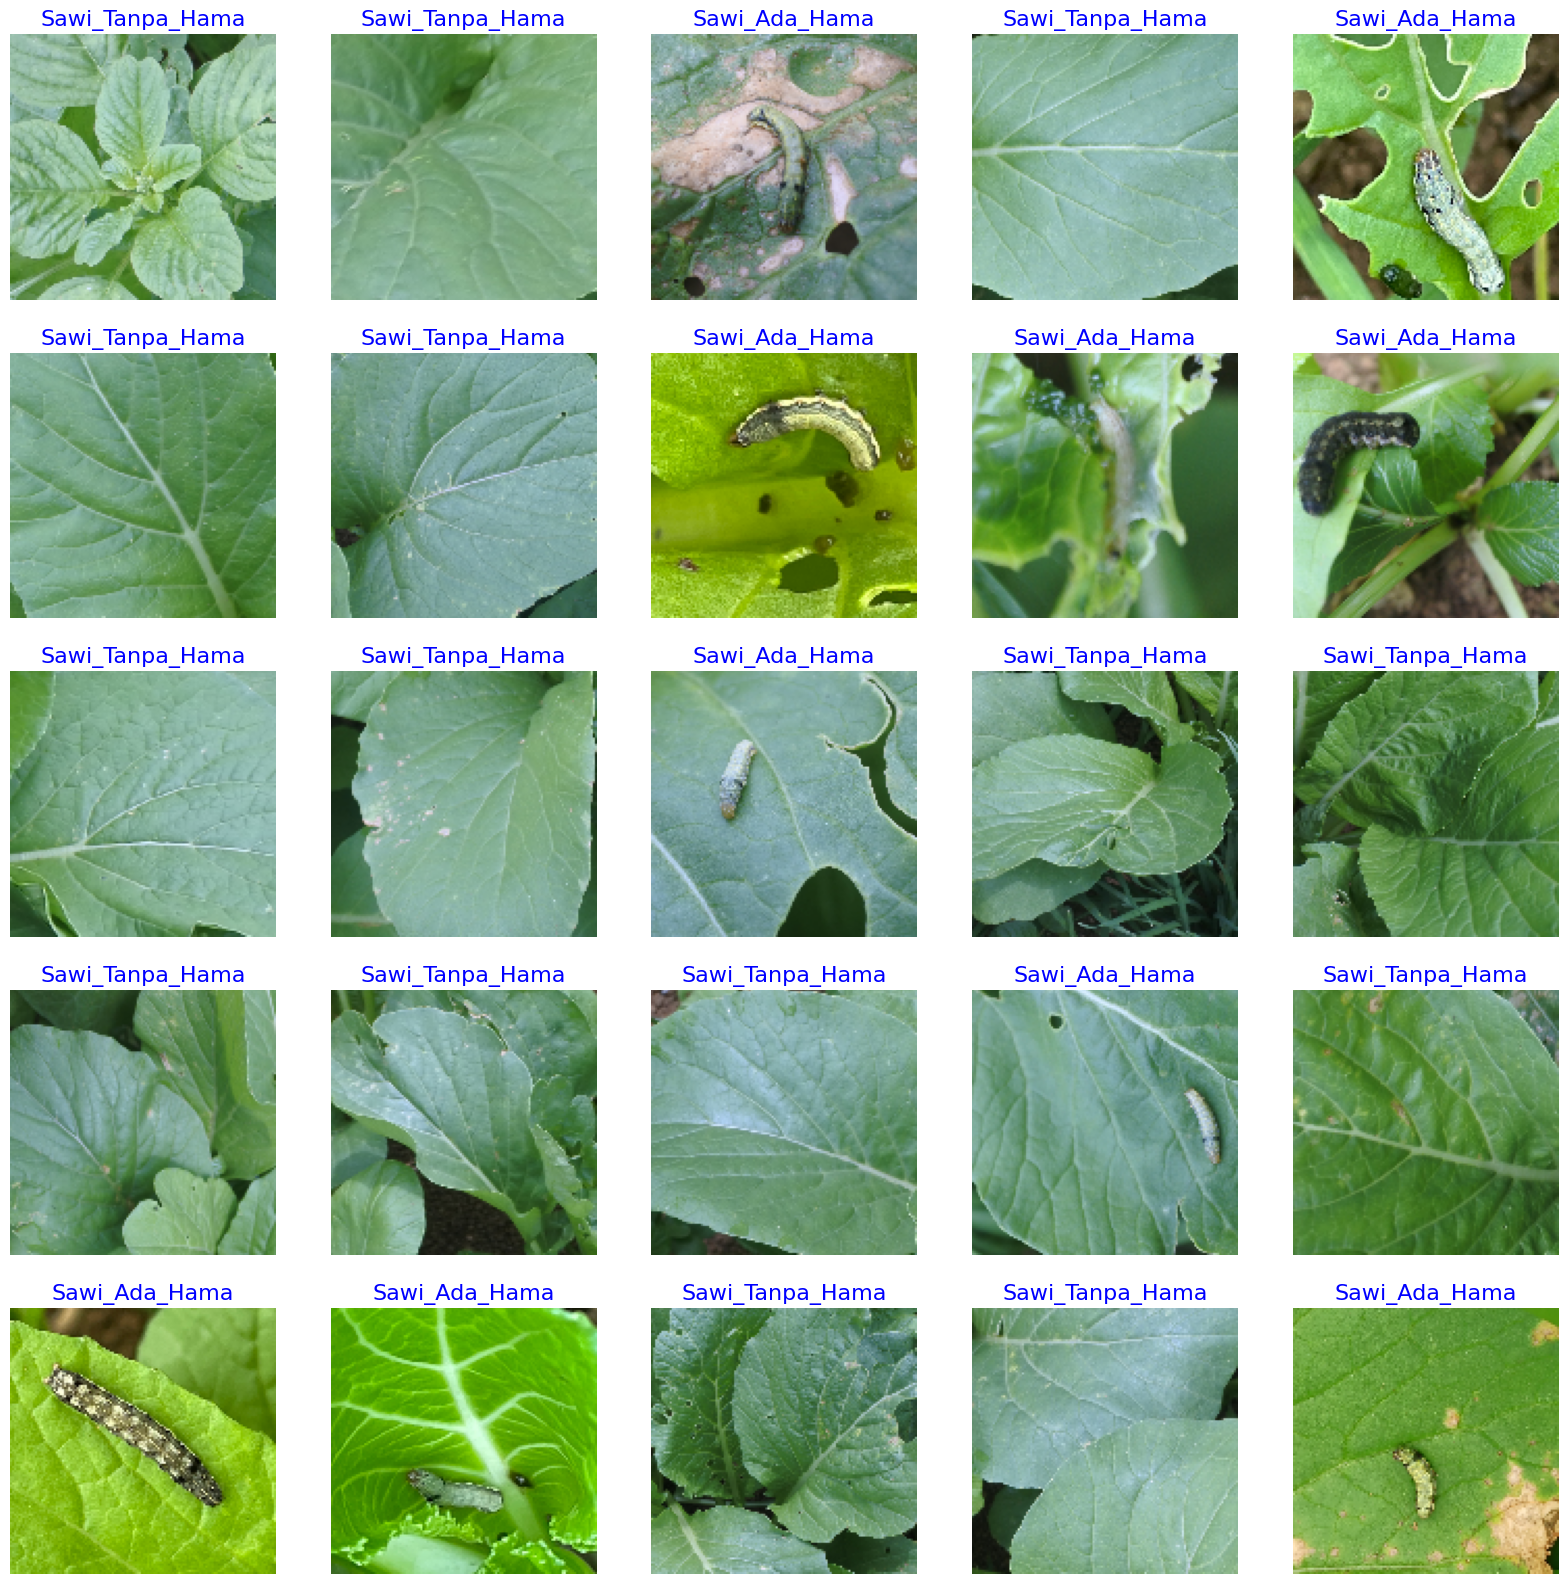

In [32]:
show_image_samples(train_gen)

In [33]:
# Membuat Model
base_model=tf.keras.applications.NASNetMobile(include_top=False, weights="imagenet",input_tensor=Input(shape=(128,128,3)))

In [34]:
base_model.summary()

Model: "nasnet_mobile"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv1 (Conv2D) │ (None, 63, 63,    │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn1            │ (None, 63, 63,    │        128 │ stem_conv1[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_188      │ (None, 63, 63,    │          0 │ stem_bn1[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reduction_conv_1_s… │ (None, 63, 63,    │        352 │ activation_188[0… │
│ (Conv2D)            │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reduction_bn_1_ste… │ (None, 63, 63,    │         44 │ reduction_conv_1… │
│ (BatchNormalizatio… │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_189      │ (None, 63, 63,    │          0 │ reduction_bn_1_s… │
│ (Activation)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_191      │ (None, 63, 63,    │          0 │ stem_bn1[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_p… │ (None, 67, 67,    │          0 │ activation_189[0… │
│ (ZeroPadding2D)     │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_p… │ (None, 69, 69,    │          0 │ activation_191[0… │
│ (ZeroPadding2D)     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_r… │ (None, 32, 32,    │        396 │ separable_conv_1… │
│ (SeparableConv2D)   │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_r… │ (None, 32, 32,    │      1,920 │ separable_conv_1… │
│ (SeparableConv2D)   │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_b… │ (None, 32, 32,    │         44 │ separable_conv_1… │
│ (BatchNormalizatio… │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_b… │ (None, 32, 32,    │         44 │ separable_conv_1… │
│ (BatchNormalizatio… │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_190      │ (None, 32, 32,    │          0 │ separable_conv_1… │
│ (Activation)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_192      │ (None, 32, 32,    │          0 │ separable_conv_1… │
│ (Activation)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_2_r… │ (None, 32, 32,    │        396 │ activation_190[0

 Total params: 4,269,716 (16.29 MB)

 Trainable params: 4,232,978 (16.15 MB)

 Non-trainable params: 36,738 (143.51 KB)

In [35]:
base_model.trainable = False

In [58]:
print("Building model with", base_model)
model = tf.keras.Sequential([
     base_model,
            tf.keras.layers.Conv2D(filters=32, padding='same', kernel_size=3, activation='relu', strides=1),
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
            tf.keras.layers.Dropout(rate=0.5),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(2, activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy'])

Building model with <Functional name=nasnet_mobile, built=True>


In [37]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ nasnet_mobile (Functional)      │ (None, 4, 4, 1056)     │     4,269,716 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 32)       │       304,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,574,134 (17.45 MB)

 Trainable params: 304,418 (1.16 MB)

 Non-trainable params: 4,269,716 (16.29 MB)

In [38]:
epochs = 10
history = model.fit(
    x=train_gen,
    epochs = epochs ,
    validation_data = valid_gen
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_790']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


13/13 ━━━━━━━━━━━━━━━━━━━━ 87s 5s/step - accuracy: 0.7714 - loss: 0.5052 - val_accuracy: 0.9000 - val_loss: 0.3850
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 71s 4s/step - accuracy: 0.9601 - loss: 0.1088 - val_accuracy: 0.8800 - val_loss: 0.2839
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.9594 - loss: 0.0858 - val_accuracy: 0.8900 - val_loss: 0.2826
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.9831 - loss: 0.0642 - val_accuracy: 0.8900 - val_loss: 0.2988
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.9829 - loss: 0.0443 - val_accuracy: 0.9000 - val_loss: 0.2595
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.9943 - loss: 0.0318 - val_accuracy: 0.9000 - val_loss: 0.2626
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.9903 - loss: 0.0308 - val_accuracy: 0.9100 - val_loss: 0.2104
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.9939 - loss: 0.0195 - val_accuracy: 0.9200 - val_loss: 0.2509
Epo

In [57]:
history = model.fit(
    x=test_gen,
    epochs = epochs ,
    validation_data = valid_gen
)

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 9s/step - accuracy: 0.9400 - loss: 0.1849 - val_accuracy: 0.9400 - val_loss: 0.2356
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 7s/step - accuracy: 0.9467 - loss: 0.1356 - val_accuracy: 0.9100 - val_loss: 0.2645
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 6s/step - accuracy: 0.9533 - loss: 0.1062 - val_accuracy: 0.9500 - val_loss: 0.1937
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 7s/step - accuracy: 0.9867 - loss: 0.0273 - val_accuracy: 0.9300 - val_loss: 0.1671
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 6s/step - accuracy: 0.9867 - loss: 0.0326 - val_accuracy: 0.9300 - val_loss: 0.1747
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 6s/step - accuracy: 0.9933 - loss: 0.0371 - val_accuracy: 0.9500 - val_loss: 0.1744
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 8s/step - accuracy: 0.9800 - loss: 0.0292 - val_accuracy: 0.9500 - val_loss: 0.1627
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 1.0000 - loss: 0.0143 - val_accuracy: 0.9300 - val_loss: 0.1680
Epoch 9/10

In [52]:
#definisikan fungsi untuk mencetak teks dengan warna depan dan latar belakang RGB
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m'
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True)
    return

In [53]:
# definisi fungsi ke plot di training data
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

In [54]:
#definisikan fungsi untuk menghasilkan confusion matrix and clasification report
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key
    classes=list(new_dict.values())
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'
    dict_path=os.path.join(save_dir,dict_name)
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)
    errors=0
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)
        true_index=labels[i]
        if pred_index != true_index:
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)
            errors=errors + 1
        y_pred.append(pred_index)
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):
                split1=os.path.split(error_list[i])
                split2=os.path.split(split1[0])
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():
            count=error_indices.count(key)
            if count!=0:
                plot_bar.append(count)
                plot_class.append(value)
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix
        cm = confusion_matrix(y_true, y_pred )
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

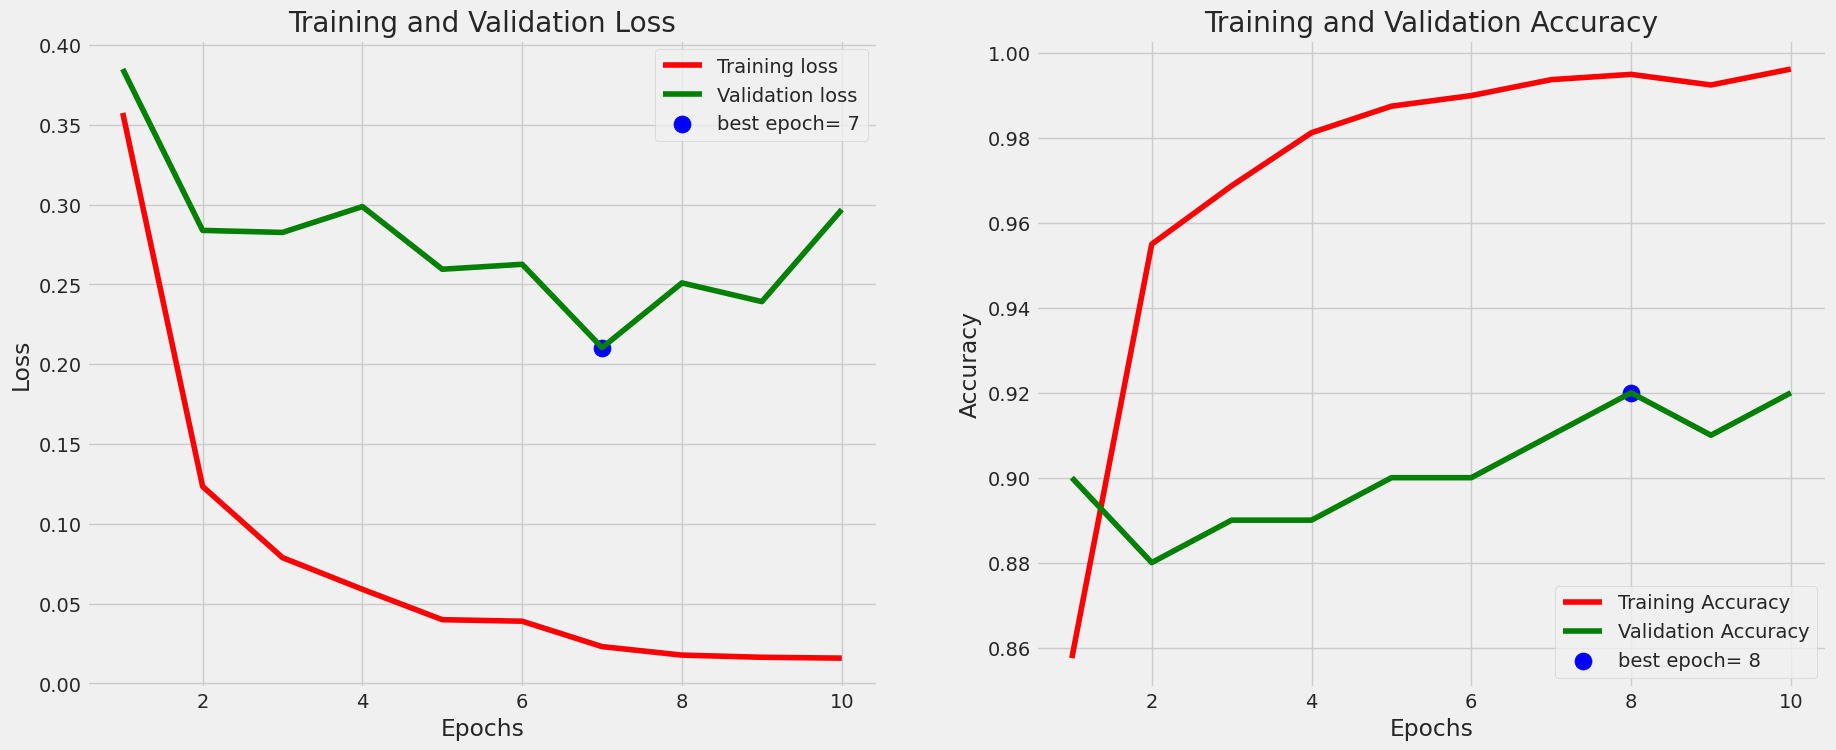

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.9467 - loss: 0.2390
Accuracy on the test set is 96.00 %



In [55]:
# Evaluasi model di data test
tr_plot(history,0)
acc = model.evaluate(test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps)[1] * 100
msg = f'Accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0, 255, 0), (55, 65, 80))

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_790']
Received: inputs=Tensor(shape=(50, 128, 128, 3))
  warnings.warn(msg)


2/2 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step


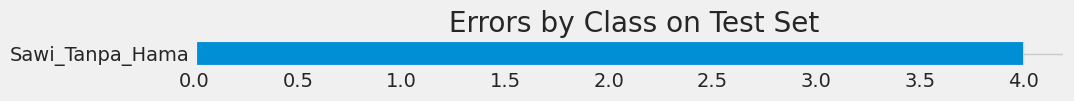

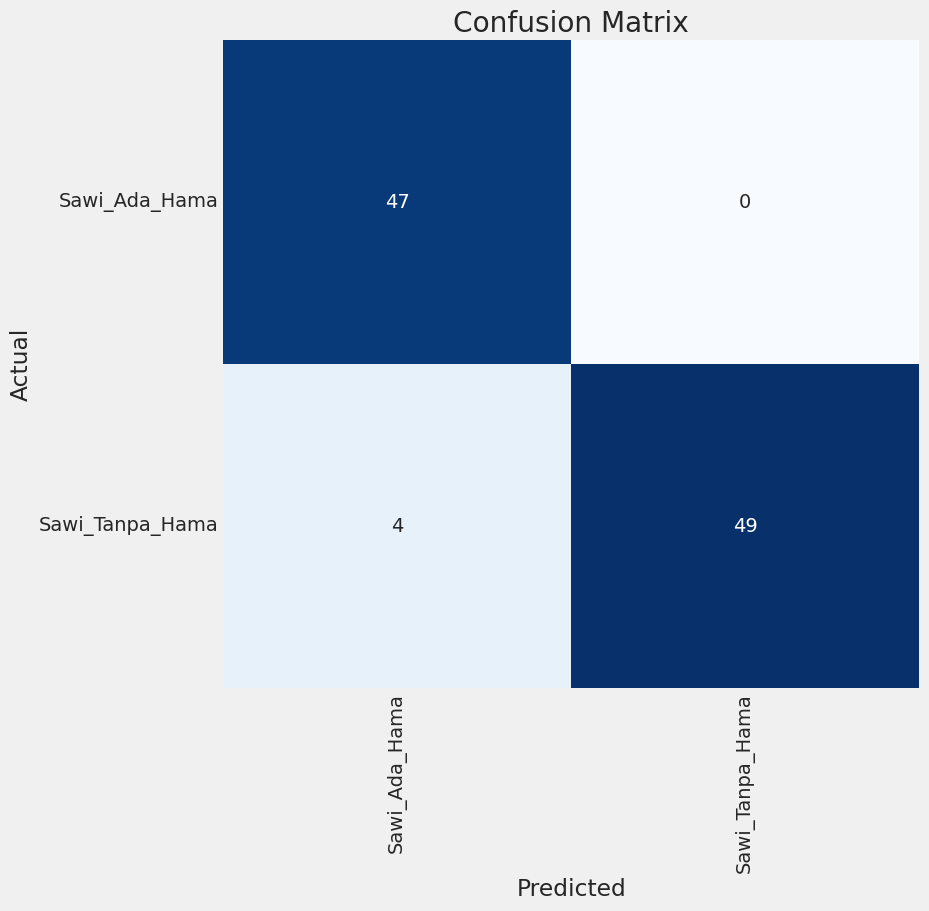

Classification Report:
----------------------
                  precision    recall  f1-score   support

  Sawi_Ada_Hama       0.92      1.00      0.96        47
Sawi_Tanpa_Hama       1.00      0.92      0.96        53

       accuracy                           0.96       100
      macro avg       0.96      0.96      0.96       100
   weighted avg       0.96      0.96      0.96       100



In [56]:
#buat prediksi pada set uji dan menghasilkan matriks kebingungan serta laporan klasifikasi
print_code=0
preds=model.predict(test_gen)
print_info( test_gen, preds, print_code, save_dir, subject )

In [66]:
# Simpan ke saved_models
saved_model_path = '/content/drive/MyDrive/Tugas Dicoding/Caisim/Dataset_Cesim/my_model'
model.export(saved_model_path)
print(f" Model disimpan sebagai SavedModel di: {saved_model_path}")

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_790']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


Saved artifact at '/content/drive/MyDrive/Tugas Dicoding/Caisim/Dataset_Cesim/my_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor_1566')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  137910769110480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137910769109904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137910769110672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137910769111056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137910769109712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137910769108944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137910440550928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137910440547664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137910440549584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137910440549776: TensorSpec(

In [61]:
# Konversi ke TFLite
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
tflite_model = converter.convert()

# Simpan ke  TFlite
tflite_path = 'model.tflite'
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)

print(f"Model berhasil dikonversi ke TFLite: {tflite_path}")

Model berhasil dikonversi ke TFLite: model.tflite


In [67]:
tfjs_output_path = '/content/drive/MyDrive/Tugas Dicoding/Caisim/Dataset_Cesim/tfjs_model'
tfjs.converters.convert_tf_saved_model(
    saved_model_dir=saved_model_path,
    output_dir=tfjs_output_path
)

print(f"✅ Model berhasil dikonversi ke TensorFlow.js di folder: {tfjs_output_path}")

✅ Model berhasil dikonversi ke TensorFlow.js di folder: /content/drive/MyDrive/Tugas Dicoding/Caisim/Dataset_Cesim/tfjs_model


In [65]:
print(f"TensorFlow version      : {tf.__version__}")
print(f"Keras version           : {keras.__version__}")
print(f"Numpy version           : {np.__version__}")
print(f"Pandas version          : {pd.__version__}")
print(f"Seaborn version         : {sns.__version__}")

TensorFlow version      : 2.18.0
Keras version           : 3.8.0
Numpy version           : 2.0.2
Pandas version          : 2.2.2
Seaborn version         : 0.13.2
